In [ ]:
from skimage import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.ensemble import IsolationForest
import cv2
import os
from sklearn.ensemble import IsolationForest

In [ ]:
#configuracion necesaria de pyplot para ver las imagenes en escala de grises
plt.rcParams['image.cmap'] = 'gray'

# comando de Jupyter para que las imagenes se muestren automaticamente 
%matplotlib inline

In [ ]:
def pixRelevant(raw, mask):
    """
    Función que devuelve las áreas relevantes para el análisis mediante aplicar una máscara
    """
    #Convertimos todos los pixelex de la máscara en 0 o 1
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j] != 0:
              mask[i][j] = 1
    relevant_img = raw * mask
    return relevant_img

In [ ]:
def numLabels(img_matrix):
    """
    Función que devuelve el número de etiquetas que usó el experto para 
    catalogar las diferentes zonas en el pulmón, se cuenta la zona 
    negra como una etiqueta.
    """
    labels_exp = []
    for i in range(img_matrix.shape[0]):
        for j in range(img_matrix.shape[1]):
            if img_matrix[i][j]  not in labels_exp:
                labels_exp.append(img_matrix[i][j])
    return len(labels_exp)

In [ ]:
def createAttrImg(img, 
                  kernel_mean = 10, 
                  kernel_gauss = 0, 
                  kernel_median = 9, 
                  canny_min = 100, 
                  canny_max = 500, 
                  d_bilateral = 10,
                  sigmaColor_bilateral = 5, 
                  sigmaSpace_bilateral = 5):

    """
    Función que devuelve un objeto de tipo DataFrame, este contiene como filas a cada uno de los pixeles de la imagen.
    cada atributo representa un filtro aplicado en la imagen.
    """
    #Sin filtro
    img_inline = np.reshape(img, (1, img.shape[0]*img.shape[1])).squeeze()
    df_img_res = pd.DataFrame(img_inline, columns=['Raw'])


    #Filtro Medio
    image_test = cv2.blur(img, (kernel_mean, kernel_mean))
    df_img_res['Mean'] = np.reshape(image_test, (1, img.shape[0]*img.shape[1])).squeeze()

    #Filtro Gaussiano
    image_test = cv2.GaussianBlur(img, (kernel_gauss, kernel_gauss), cv2.BORDER_DEFAULT)
    df_img_res['Gauss'] = np.reshape(image_test, (1, img.shape[0]*img.shape[1])).squeeze()

    #Filtro Mediano
    image_test = cv2.medianBlur(img, kernel_median)
    df_img_res['Median'] = np.reshape(image_test, (1, img.shape[0]*img.shape[1])).squeeze()

    #Filtro Conny
    image_test = cv2.Canny(img, canny_min, canny_max)
    df_img_res['Conny'] = np.reshape(image_test, (1, img.shape[0]*img.shape[1])).squeeze()

    #Filtro Horizontal
    kernel = np.array([[-1.0, -1.0, -1.0], 
                   [2.0, 2.0, 2.0],
                   [-1.0, -1.0, -1.0]])
    image_test = cv2.filter2D(img, -1, kernel)
    df_img_res['Horizontal'] = np.reshape(image_test, (1, img.shape[0]*img.shape[1])).squeeze()

    #Filtro Vertical
    kernel = np.array([[-1.0, 2.0, -1.0], 
                   [-1.0, 2.0, -1.0],
                   [-1.0, 2.0, -1.0]])
    image_test = cv2.filter2D(img, -1, kernel)
    df_img_res['Vertical'] = np.reshape(image_test, (1, img.shape[0]*img.shape[1])).squeeze()

    #Filtro Laplaciano
    kernel = np.array([[0.0, -1.0, 0.0], 
                   [-1.0, 4.0, -1.0],
                   [0.0, -1.0, 0.0]])
    image_test = cv2.filter2D(img,-1, kernel)
    df_img_res['Laplacian'] = np.reshape(image_test, (1, img.shape[0]*img.shape[1])).squeeze()

    #Filtro Bilateral
    image_test = cv2.bilateralFilter(img, d_bilateral, sigmaColor_bilateral, sigmaSpace_bilateral, cv2.BORDER_DEFAULT)
    df_img_res['Bilateral'] = np.reshape(image_test, (1, img.shape[0]*img.shape[1])).squeeze()
    
    return df_img_res

In [ ]:
def labels_iForest(attr, shape_img_output, grade):
    """
    La función aplicaráa Isolation Forest a un conjunto de datos de atributos de una imagen, 
    posteriormente etiquetará cada vector dependiendo del grado que sea ingresado.
    Entrada:
        attr: Conjunto de datos con atributos de una imagen.
        shape_img_output: Especifica las dimensiones de salida de la imagen.
        grade: núúmero de etiquetas que se aplicarán al conjunto.
    Salida:
        labels: Etiquetas para cada vector.
    """
    # Se selecciona la cantidad de árboles y máximo tamaño de los árboles,
    # según la publicación original.
    clf = IsolationForest(n_estimators=100, max_samples=256)
    clf.fit(attr)
    outlier_score_img = np.floor(-grade * clf.score_samples(attr))
    return np.reshape(outlier_score_img, shape_img_output)

#Pruebas

In [ ]:
imgs_train = os.listdir("/content/drive/MyDrive/comia2021/Train")

In [ ]:
imgs_lung_mask = os.listdir("/content/drive/MyDrive/comia2021/LungMask")

In [ ]:
imgs_train.sort()
imgs_lung_mask.sort()

In [ ]:
imgs_train

['tr_im1.png',
 'tr_im10.png',
 'tr_im2.png',
 'tr_im3.png',
 'tr_im4.png',
 'tr_im5.png',
 'tr_im6.png',
 'tr_im7.png',
 'tr_im8.png',
 'tr_im9.png']

In [ ]:
imgs_lung_mask

['tr_lungmask1.png',
 'tr_lungmask10.png',
 'tr_lungmask2.png',
 'tr_lungmask3.png',
 'tr_lungmask4.png',
 'tr_lungmask5.png',
 'tr_lungmask6.png',
 'tr_lungmask7.png',
 'tr_lungmask8.png',
 'tr_lungmask9.png']

In [ ]:
for i in range(1, 11):
    train_tmp  = io.imread("/content/drive/MyDrive/comia2021/Train/tr_im{}.png".format(i))
    lung_mask_tmp = io.imread("/content/drive/MyDrive/comia2021/LungMask/tr_lungmask{}.png".format(i))
    train_lung_mask_tmp = pixRelevant(train_tmp, lung_mask_tmp)
    df_tmp = createAttrImg(train_lung_mask_tmp)
    df_tmp.to_csv("/content/drive/MyDrive/comia2021/Attr/attr_img{}.csv".format(i), sep='\t', index=None)
    

#Prueba de iForest

Seleccionamos la lista de conjuntos de datos que se crearon anteriormente.

In [ ]:
list_attr_tmp = os.listdir("/content/drive/MyDrive/comia2021/Attr")

In [ ]:
# Seleccionamos solo los archivos con extensión CSV
list_attr = []
for i in range(len(list_attr_tmp)):
    if list_attr_tmp[i].split('.')[1] == 'csv':
        list_attr.append(list_attr_tmp[i])

In [ ]:
list_attr.sort()

In [ ]:
list_attr

['attr_img1.csv',
 'attr_img10.csv',
 'attr_img2.csv',
 'attr_img3.csv',
 'attr_img4.csv',
 'attr_img5.csv',
 'attr_img6.csv',
 'attr_img7.csv',
 'attr_img8.csv',
 'attr_img9.csv']

Extraemos la lista de imágenes que contienen las máscaras creadas por el experto.

In [ ]:
list_img_exp_tmp = os.listdir("/content/drive/MyDrive/comia2021/Mask")

In [ ]:
# Seleccionamos solo los archivos con extensión PNG
list_img_exp = []
for i in range(len(list_img_exp_tmp)):
    if list_img_exp_tmp[i].split('.')[1] == 'png':
        list_img_exp.append(list_img_exp_tmp[i])

In [ ]:
list_img_exp.sort()

In [ ]:
list_img_exp

['tr_mask1.png',
 'tr_mask10.png',
 'tr_mask2.png',
 'tr_mask3.png',
 'tr_mask4.png',
 'tr_mask5.png',
 'tr_mask6.png',
 'tr_mask7.png',
 'tr_mask8.png',
 'tr_mask9.png']

In [ ]:
for i in range(1, 11):
    mask_exp_tmp = io.imread("/content/drive/MyDrive/comia2021/Mask/tr_mask{}.png".format(i))
    labels_mask_tmp = numLabels(mask_exp_tmp)
    df_tmp = pd.read_csv("/content/drive/MyDrive/comia2021/Attr/attr_img{}.csv".format(i), sep='\t')
    labels_tmp = labels_iForest(df_tmp, (512, 512), labels_mask_tmp)
    df_out = pd.DataFrame(np.reshape(labels_tmp, (262144, 1)), columns=(['Label']), index=None)
    df_out.to_csv("/content/drive/MyDrive/comia2021/Result_Data/res_data{}.csv".format(i), sep='\t')
    io.imsave("/content/drive/MyDrive/comia2021/Result_Image/res_img{}.png".format(i), labels_tmp)

##Validación de área de interés

In [ ]:
list_img_res_tmp = os.listdir("/content/drive/MyDrive/comia2021/Result_Image")
# Seleccionamos solo los archivos con extensión PNG
list_img_res = []
for i in range(len(list_img_res_tmp)):
    if list_img_res_tmp[i].split('.')[1] == 'png':
        list_img_res.append(list_img_res_tmp[i])
list_img_res.sort()
list_img_res

['res_img1.png',
 'res_img10.png',
 'res_img2.png',
 'res_img3.png',
 'res_img4.png',
 'res_img5.png',
 'res_img6.png',
 'res_img7.png',
 'res_img8.png',
 'res_img9.png']

In [ ]:
imgs_lung_mask

['tr_lungmask1.png',
 'tr_lungmask10.png',
 'tr_lungmask2.png',
 'tr_lungmask3.png',
 'tr_lungmask4.png',
 'tr_lungmask5.png',
 'tr_lungmask6.png',
 'tr_lungmask7.png',
 'tr_lungmask8.png',
 'tr_lungmask9.png']

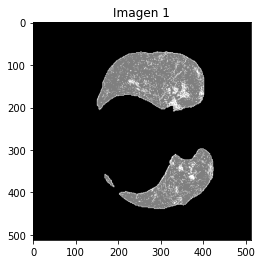

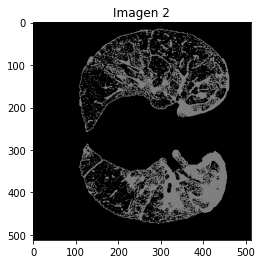

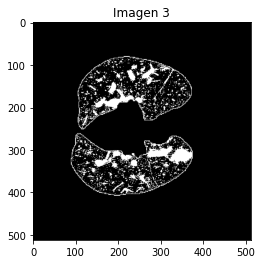

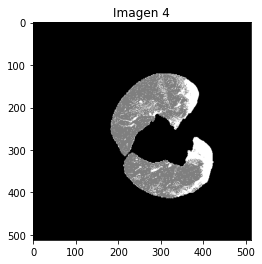

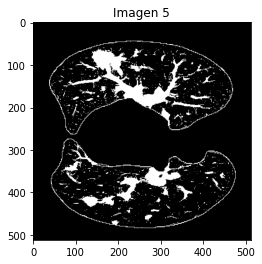

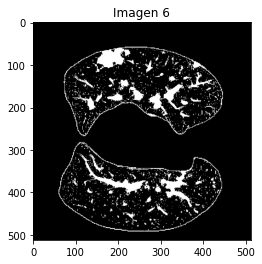

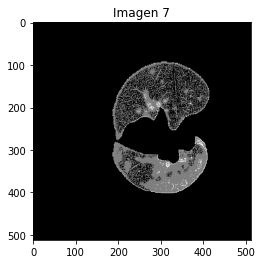

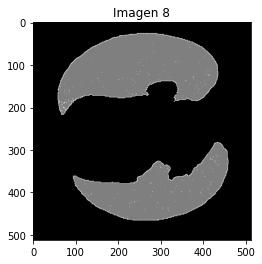

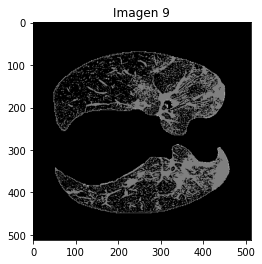

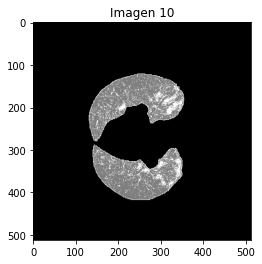

In [ ]:
img = 1
for i in range(1, 11):
    img_lung_tmp = io.imread("/content/drive/MyDrive/comia2021/LungMask/tr_lungmask{}.png".format(i))
    #Convertimos todos los pixelex de la máscara en 0 o 1
    for k in range(img_lung_tmp.shape[0]):
        for j in range(img_lung_tmp.shape[1]):
            if img_lung_tmp[k][j] != 0:
              img_lung_tmp[k][j] = 1

    img_res_tmp = io.imread("/content/drive/MyDrive/comia2021/Result_Image/res_img{}.png".format(i))
    img_final = img_lung_tmp * img_res_tmp
    
    plt.imshow(img_final)
    plt.title("Imagen {}".format(i))
    plt.show()
    
    #relevant_img = raw * img_lung_tmp
    #return relevant_img
    

##FIN Validación de área de interés

In [ ]:
df_img1 = pd.read_csv("/content/drive/MyDrive/comia2021/Attr/attr_img1.csv", sep='\t')


In [ ]:
labels_img1 = labels_iForest(df_img1, (512, 512), 3)

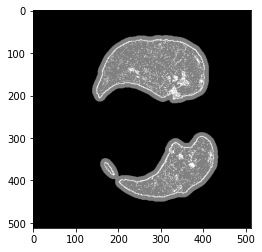

In [ ]:
plt.imshow(labels_img1)

In [ ]:
clf = IsolationForest(n_estimators=100, max_samples=256)

In [ ]:
clf.fit(df_img1)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=256, n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

In [ ]:
outlier_score_img1 = -1 * clf.score_samples(df_img1)

In [ ]:
Counter(outlier_score_img1 > 0.5)

Counter({False: 209455, True: 52689})

#Se comienza con la comparación

In [ ]:
mask_exp1 = io.imread("/content/drive/MyDrive/comia2021/Mask/tr_mask1.png")

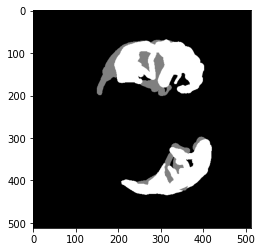

In [ ]:
plt.imshow(mask_exp1)

In [ ]:
num_labels = numLabels(mask_exp1)

In [ ]:
outlier_label_img1 = np.floor(num_labels * outlier_score_img1)

NameError: ignored

In [ ]:
Counter(outlier_label_img1)

NameError: ignored

In [ ]:
df_img1['Label'] = np.array(outlier_label_img1, dtype=int)

NameError: ignored

In [ ]:
img_outlier = np.reshape(outlier_label_img1, (512, 512))

NameError: ignored

In [ ]:
plt.imshow(img_outlier)

NameError: ignored